<h1 style="text-align: center;">Финальный проект: телекоммуникации</h1>

Оператор связи **«ТелеДом»** хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

**Цель:** Необходимо разработать модель, которая будет предсказывать, разорвёт ли абонент договор (прогноз оттока клиентов). 

**Данные:** Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Целевая метрика:** ROC-AUC >= 0.85

# Содержание:
* [Импорт необходимых библиотек](#step1)
* [Описание данных](#step2)
* [Загрузка данных](#step3)
* [Предварительный анализ и предобработка данных](#step4)
* [Объединение данных](#step5)
* [Исследовательский анализ и предобработка данных объединённого датафрейма](#step6)
* [Подготовка данных для моделей](#step7)
* [Обучение моделей](#step8)
* [Анализ важности признаков](#step9)
* [Общий вывод](#step10)

# Импорт необходимых библиотек <a class="anchor" id="step1"></a>

In [1]:
pip install --upgrade -q scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install lightgbm

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    MinMaxScaler
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Константы

In [5]:
RANDOM_STATE=190525
TEST_SIZE=0.25
LOAD_DATE = pd.Timestamp('2020-02-01')

# Описание данных <a class="anchor" id="step2"></a>

`contract_new.csv` — информация о договоре

Признак          | Описание
-----------------|------------------------------------------
customerID       | идентификатор абонента
BeginDate        | дата начала действия договора
Type             | тип оплаты: раз в год-два или ежемесячно
PaperlessBilling | электронный расчётный лист
PaymentMethod    | тип платежа
MonthlyCharges   | расходы за месяц
TotalCharges     | общие расходы абонента
**EndDate**      | дата окончания действия договора

`personal_new.csv` — персональные данные клиента

Признак       | Описание
--------------|----------
customerID    | идентификатор пользователя
gender        | пол
SeniorCitizen | является ли абонент пенсионером
Partner       | есть ли у абонента супруг или супруга
Dependents    | есть ли у абонента дети

`internet_new.csv` — информация об интернет-услугах

Признак          | Описание
-----------------|-------------------------------------------------------------
customerID       | идентификатор пользователя
InternetService  | тип подключения
OnlineSecurity   | блокировка опасных сайтов
OnlineBackup     | облачное хранилище файлов для резервного копирования данных
DeviceProtection | антивирус
TechSupport      | выделенная линия технической поддержки
StreamingTV      | стриминговое телевидение
StreamingMovies  | каталог фильмов

`phone_new.csv` — информация об услугах телефонии

Признак       | Описание
--------------|-------------------------------------------------------
customerID    | идентификатор пользователя
MultipleLines | подключение телефона к нескольким линиям одновременно

# Загрузка данных <a class="anchor" id="step3"></a>

In [6]:
try:

    contract_df = pd.read_csv('./datasets/contract_new.csv')
    personal_df = pd.read_csv('./datasets/personal_new.csv')
    internet_df = pd.read_csv('./datasets/internet_new.csv')
    phone_df = pd.read_csv('./datasets/phone_new.csv')

except:
    contract_df = pd.read_csv('/datasets/contract_new.csv')
    personal_df = pd.read_csv('/datasets/personal_new.csv')
    internet_df = pd.read_csv('/datasets/internet_new.csv')
    phone_df = pd.read_csv('/datasets/phone_new.csv')

Выполним первичный осмотр данных.

**contract_df**

In [7]:
contract_df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


Требуется преобразование названий столбцов в snake_case. Целевой признак - EndData, представлен в виде либо даты окончания, либо отсутствия даты. Требуется преобразование целевого признака в бинарный вид.

In [8]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков не наблюдается. Необходимо преобразовать тип данных BeginDate и EndDate в datetime, TotalCharges во float64. Остальные типы данных удовлетворяют условиям.

In [9]:
contract_df['customerID'].describe()

count           7043
unique          7043
top       8150-QUDFX
freq               1
Name: customerID, dtype: object

Количество уникальных customerID совпадает с количеством записей, что позволяет исключить наличие явных дубликатов.

**personal_df**

In [10]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Также необходимо преобразование названий в snake_case, пропусков не наблюдается, записей ровно столько же сколько в главной таблице (предполагаем, что данные по каждому клиенту), тип данных SeniorCitizen можно преобразовать в int32 для экономии памяти.

In [12]:
personal_df['customerID'].describe()

count           7043
unique          7043
top       8150-QUDFX
freq               1
Name: customerID, dtype: object

Количество уникальных customerID совпадает с количеством записей, что позволяет исключить наличие явных дубликатов.

**internet_df**

In [13]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [14]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Также необходимо преобразование названий в snake_case, пропусков не наблюдается, однако записей меньше, чем в предыдущих двух таблицах, что говорит о том, что не все клиенты пользуются услугами интернета. Типы данных корректные.

In [15]:
internet_df.describe().T

,count,unique,top,freq
customerID,5517,5517,4009-ALQFH,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


Отмечаем, что количество уникальных customerID совпадает с количеством записей, что позволяет исключить наличие явных дубликатов. Почти во всех услугах имеется всего 2 уникальных варианта ответа это Yes или No, во всех случаях ответ No превышает половину всех ответов, то есть различными интернет услугами пользуется меньше половины клиентов с подключенным интернетом. 

**phone_df**

In [16]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [17]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [18]:
phone_df.describe().T

,count,unique,top,freq
customerID,6361,6361,8150-QUDFX,1
MultipleLines,6361,2,No,3390


Также необходимо преобразование названий в snake_case, пропусков не наблюдается, также записей меньше, чем всего клиентов, что говорит о том, что не все клиенты пользуются телефонными услугами. Типы данных корректные, явные дубликаты исключены, имеются 2 варианта ответа Yes и No по услуге, ответ No незначительно преобладает.

# Предварительный анализ и предобработка данных <a class="anchor" id="step4"></a>

In [19]:
sns.set_style("darkgrid")

## Преобразование типов данных

Преобразуем названия столбцов во всех таблицах в snake_case.

In [20]:
def to_snake_case(df):
    df.columns = (df.columns
                    .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                    .str.lower()
                 )

In [21]:
to_snake_case(contract_df)
to_snake_case(personal_df)
to_snake_case(internet_df)
to_snake_case(phone_df)

Преобразуем типы данных:
- из end_date создадим целевой признак - **leave**
- begin_date и end_date переведём в datetime
- total_charges во float64
- secior_citizen в int32

In [22]:
contract_df['leave'] = contract_df['end_date'].apply(lambda x: 0 if x == 'No' else 1)
contract_df['leave'] = contract_df['leave'].astype('int32')

In [23]:
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'])

In [24]:
contract_df['end_date'] = contract_df['end_date'].apply(lambda x: np.nan if x == 'No' else x)
contract_df['end_date'] = pd.to_datetime(contract_df['end_date'])

При попытке преобразовать тип данных у признака total_charges, выясняем, что имеются пропуски, данные в виде пустых строк. Применим преобразование с использованием функции, которая на месте пропусков поставит NaN.

In [25]:
def to_float(value):
    try:
        return float(value)
    except:
        return np.nan

In [26]:
contract_df['total_charges'] = contract_df['total_charges'].apply(to_float)

In [27]:
contract_df['total_charges'].isna().sum()

11

Имеются 11 пропусков, посмотрим что это за данные.

In [28]:
contract_df[contract_df['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,leave
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,0


Наблюдаем, что это новые клиенты, которые очевидно ещё не вносили плату ни за один месяц. С уверенностью заменим NaN на ноль.

In [29]:
contract_df['total_charges'] = contract_df['total_charges'].fillna(0)

In [30]:
contract_df.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,leave
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,0
5,9305-CDSKC,2019-03-01,NaT,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,NaT,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


In [31]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   leave              7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB


После всех необходимых преобразоаний наблюдаем, что по признаку end_date наблюдается множество пропусков, что означает, что большая часть клиентов ещё не покинула компанию. Целевой признак создан, все типы данных преобразованы в корректные.

In [32]:
personal_df['senior_citizen'] = personal_df['senior_citizen'].astype('int32')

## Исследовательский анализ данных

## Категориальные признаки contract_df

In [33]:
contract_df['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Обратим внимание, что у признака payment_method имеются два значения с подписью automatic в скобках. Уберем эту дополнительную подпись, чтобы сократить визуально в дальнейшем вывод названий этих двух категорий, уникальность категории от этого не пострадает.

In [34]:
contract_df['payment_method'] = contract_df['payment_method'].replace('Bank transfer (automatic)', 'Bank transfer')
contract_df['payment_method'] = contract_df['payment_method'].replace('Credit card (automatic)', 'Credit card')

In [35]:
contract_df['payment_method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

Замена выполнена успешно.

In [36]:
contract_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,leave
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer,42.30,1960.60,0
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,0


Посмотрим на распределение категориальных признаков.

In [37]:
contract_df['type'].value_counts().reset_index()

,index,type
0,Month-to-month,3875
1,Two year,1695
2,One year,1473


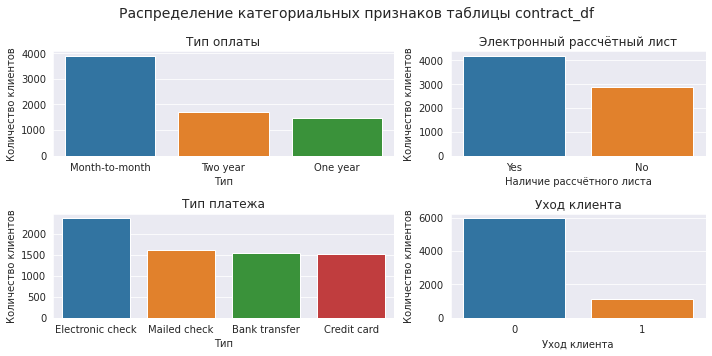

In [38]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5), gridspec_kw=dict(width_ratios=[4, 3]))
f.suptitle("Распределение категориальных признаков таблицы contract_df", fontsize=14)

ax1.set_title("Тип оплаты")
sns.barplot(data=contract_df['type'].value_counts().reset_index(), x="index", y='type', ax=ax1)
ax1.set_xlabel('Тип')
ax1.set_ylabel('Количество клиентов')

ax2.set_title("Электронный рассчётный лист")
sns.barplot(data=contract_df['paperless_billing'].value_counts().reset_index(), x="index", y='paperless_billing', ax=ax2)
ax2.set_xlabel('Наличие рассчётного листа')
ax2.set_ylabel('Количество клиентов')

ax3.set_title("Тип платежа")
sns.barplot(data=contract_df['payment_method'].value_counts().reset_index(), x="index", y='payment_method', ax=ax3)
ax3.set_xlabel('Тип')
ax3.set_ylabel('Количество клиентов')

ax4.set_title("Уход клиента")
sns.barplot(data=contract_df['leave'].value_counts().reset_index(), x="index", y="leave", ax=ax4)
ax4.set_xlabel('Уход клиента')
ax4.set_ylabel('Количество клиентов')

f.tight_layout()
plt.show();

Наблюдения:
- целевой признак не сбалансирован, уходящих клиентов намного меньше, чем остающихся
- большинство клиентов выбирают помесячную оплату
- чаще всего выбирают тип платежа Electronic check
- большинство клиентов предпочитают электронный рассчетный лист

## Datetime признаки contract_df

Для начала проверим наличие аномальных записей, в которых дата начала может превышать дату загрузки или дата начала оепрежает дату окончания.

In [39]:
contract_df[(contract_df['begin_date'] > LOAD_DATE) | (contract_df['end_date'] < contract_df['begin_date'])].shape[0]

0

Аномалий по дате не обнаружено. Проведём анализ - посмотрим на распределение дат и количество клиентов. Обратим внимание на то, что дата начала контракта у всех клиентов стоит 1 числа, что означает наличие помесячной статистики.

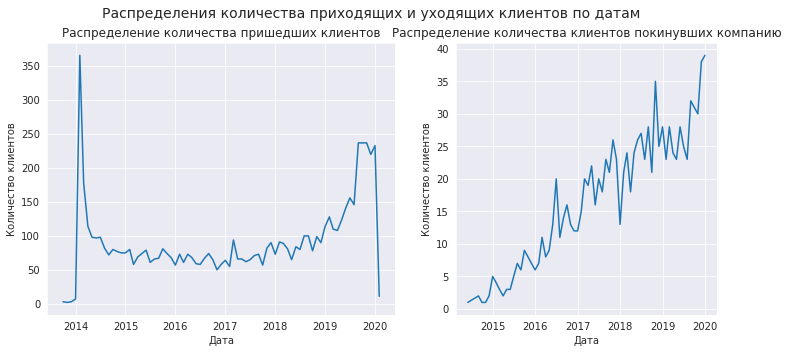

In [40]:
f, axs = plt.subplots(1, 2, figsize=(12,5), gridspec_kw=dict(width_ratios=[4, 3]))
f.suptitle('Распределения количества приходящих и уходящих клиентов по датам', fontsize=14)

begin_date_customers = contract_df.groupby('begin_date')['customer_id'].count().reset_index()
sns.lineplot(data=begin_date_customers, x='begin_date', y='customer_id', ax=axs[0])
axs[0].set_title('Распределение количества пришедших клиентов')
axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Количество клиентов')

end_date_customers = contract_df[~contract_df['end_date'].isna()].groupby('end_date')['customer_id'].count().reset_index()
sns.lineplot(data=end_date_customers, x='end_date', y='customer_id', ax=axs[1])
axs[1].set_title('Распределение количества клиентов покинувших компанию')
axs[1].set_xlabel('Дата')
axs[1].set_ylabel('Количество клиентов')

plt.show();

Наблюдения:
- имеется информация о приходящих клиентах с 2014 по 2020 год
- в первые месяцы существования компании наблюдается резкий прилив новых клиентов
- со второй половины 2014 года по 2019 год приходило в среднем от 50 до 100 новых клиентов ежемесячно
- с 2019 года наблюдается достаточно резкий рост прихода новых клиентов
- на всём протяжении существования компании наблюдается тенденция к увеличению количества клиентов покидающих компанию, что на уровне практически неизменного количества приходящих клиентов является негативным трендом
- максимальное число ушедших клиентов за месяц почти достигает 40 и продолжает расти

## Количественные признаки contract_df

Проведём анализ расходов клиентов. Создадим функцию, которая нарисует графики распределений расходов.

In [41]:
def print_charges(feature_name, title, x_label):
    f, axs = plt.subplots(2, 1, figsize=(8,5), gridspec_kw={'height_ratios': [2, 0.5]})
    f.suptitle(title)
    
    sns.histplot(contract_df[feature_name], kde=True, ax=axs[0])
    sns.boxplot(contract_df[feature_name], orient='h', ax=axs[1])
    
    axs[1].set_xlabel(x_label)
    axs[0].set_ylabel('Частота')
    axs[0].set_xlabel('')
    
    plt.show();

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


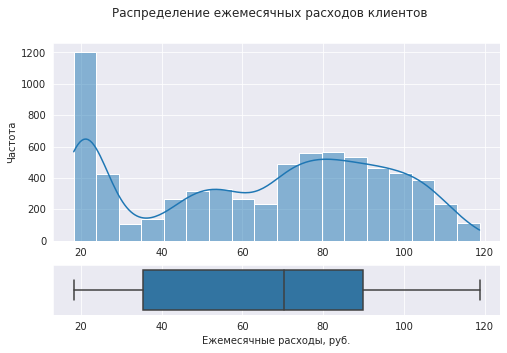

In [42]:
print_charges('monthly_charges', 'Распределение ежемесячных расходов клиентов', 'Ежемесячные расходы, руб.')

Наблюдения:
- траты клиентов ежемесячно варьируются от 10 до 120 руб
- в среднем клиенты тратят около 70 руб каждый месяц
- чаще всего клиенты тратят сумму меньше 30 руб
- выбросов по признаку не наблюдается

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


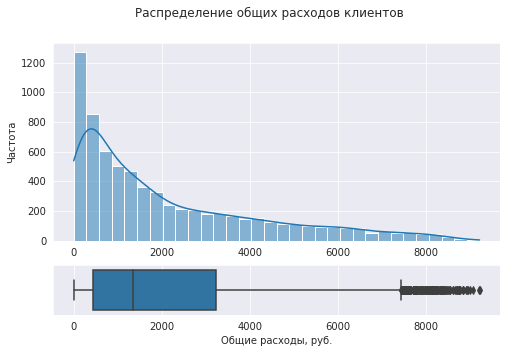

In [43]:
print_charges('total_charges', 'Распределение общих расходов клиентов', 'Общие расходы, руб.')

Наблюдения:
- график напоминает распределение Пуассона, чем больше расходы, тем меньше клиентов с данными расходами
- в среднем клиенты тратят около 1.6 тыс. руб в общем
- чаще всего общие расходы клиентов составляют менее 1 тыс. руб
- реже всего встречаются общие расходы более 4 тыс. руб
- имеются выбросы - значения более 7.5 тыс. руб
- выбросов много, что означает, что данные значения хоть и редкость, но вполне могут быть реальными, оставим их без изменений

## Распределение признаков personal_df

В данной таблице все признаки категориальные, посмотрим на их распределение.

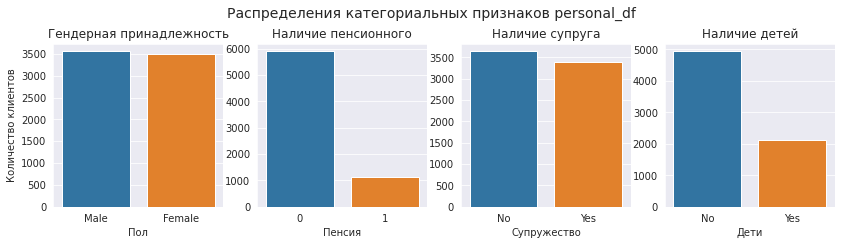

In [44]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14,3))
f.suptitle('Распределения категориальных признаков personal_df', y=1.05, fontsize=14)

sns.barplot(data=personal_df['gender'].value_counts().reset_index(), y="gender", x='index', ax=ax1)
ax1.set_title('Гендерная принадлежность')
ax1.set_xlabel('Пол')
ax1.set_ylabel('Количество клиентов')

sns.barplot(data=personal_df['senior_citizen'].value_counts().reset_index(), y="senior_citizen", x='index', ax=ax2)
ax2.set_title('Наличие пенсионного')
ax2.set_xlabel('Пенсия')
ax2.set_ylabel('')

sns.barplot(data=personal_df['partner'].value_counts().reset_index(), y="partner", x='index', ax=ax3)
ax3.set_title('Наличие супруга')
ax3.set_xlabel('Супружество')
ax3.set_ylabel('')

sns.barplot(data=personal_df['dependents'].value_counts().reset_index(), y="dependents", x='index', ax=ax4)
ax4.set_title('Наличие детей')
ax4.set_xlabel('Дети')
ax4.set_ylabel('')

plt.show();

Наблюдения:
- клиентов мужского и женского пола имеется поровну
- приблизительно 1/7 часть клиентов пенсионеры
- клиентов без наличия супруга(ги) незначительно больше
- приблизительно 2/7 части клиентов имеют детей

## Распределение признаков internet_df

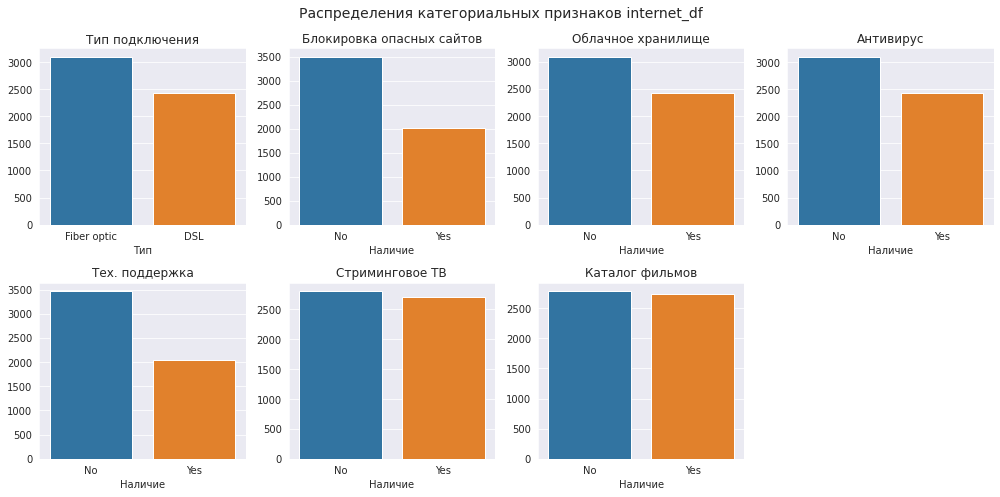

In [45]:
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(14,7))
f.suptitle('Распределения категориальных признаков internet_df', fontsize=14)
#f.ylabel('Количество клиентов')

sns.barplot(data=internet_df['internet_service'].value_counts().reset_index(), y="internet_service", x='index', ax=ax1)
ax1.set_title('Тип подключения')
ax1.set_xlabel('Тип')
ax1.set_ylabel('')

sns.barplot(data=internet_df['online_security'].value_counts().reset_index(), y="online_security", x='index', ax=ax2)
ax2.set_title('Блокировка опасных сайтов')
ax2.set_xlabel('Наличие')
ax2.set_ylabel('')

sns.barplot(data=internet_df['online_backup'].value_counts().reset_index(), y="online_backup", x='index', ax=ax3)
ax3.set_title('Облачное хранилище')
ax3.set_xlabel('Наличие')
ax3.set_ylabel('')

sns.barplot(data=internet_df['device_protection'].value_counts().reset_index(), y="device_protection", x='index', ax=ax4)
ax4.set_title('Антивирус')
ax4.set_xlabel('Наличие')
ax4.set_ylabel('')

sns.barplot(data=internet_df['tech_support'].value_counts().reset_index(), y="tech_support", x='index', ax=ax5)
ax5.set_title('Тех. поддержка')
ax5.set_xlabel('Наличие')
ax5.set_ylabel('')

sns.barplot(data=internet_df['streaming_tv'].value_counts().reset_index(), y="streaming_tv", x='index', ax=ax6)
ax6.set_title('Стриминговое ТВ')
ax6.set_xlabel('Наличие')
ax6.set_ylabel('')

sns.barplot(data=internet_df['streaming_movies'].value_counts().reset_index(), y="streaming_movies", x='index', ax=ax7)
ax7.set_title('Каталог фильмов')
ax7.set_xlabel('Наличие')
ax7.set_ylabel('')

ax8.axis('off')
f.tight_layout()
plt.show();

Наблюдения:
- преобладает тип подключения fiber optic
- примерно треть клиентов предпочитает подключать блокировку опасных сайтов
- чаще клиенты отказываются от облачного хранилища, антивируса и отдельной линии тех. поддержки, однако процент подключений не такой низкий
- стриминговое ТВ и каталог фильмов подключают примерно половина клиентов

## Распределение phone_df

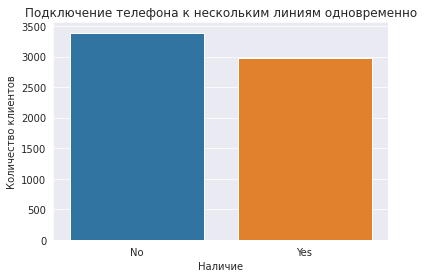

In [46]:
sns.barplot(data=phone_df['multiple_lines'].value_counts().reset_index(), x='index', y='multiple_lines')
plt.title('Подключение телефона к нескольким линиям одновременно')
plt.xlabel('Наличие')
plt.ylabel('Количество клиентов')
plt.show();

Чуть меньше половины клиентов подключают телефон к нескольким линиям одновременно.

## Промежуточные выводы

Основные выводы:
- целевой признак несбалансирован
- аномальных записей в датасете не обнаружено
- наблюдаются выбросы по признаку общие расходы - оставлены без изменений
- последний рост помесячного количества новых клиентов начался с 2019 года
- имеется тенденция к постепенному увеличению количества клиентов покидающих компанию на всём временном промежутке
- с 2015 по 2019 приходило от 50 до 100 клиентов каждый месяц
- в среднем клиенты тратят около 70 руб каждый месяц
- чаще всего клиенты тратят менее 30 руб каждый месяц
- в среднем клиенты тратят около 1.6 тыс. руб в общем
- чаще всего общие расходы клиентов не превышают 1 тыс. руб
- реже всего встречаются общие расходы более 4 тыс. руб
- клиентов женского и мужского рода поровну

# Объединение данных <a class="anchor" id="step5"></a>

Объединим все таблицы в одну по признаку customer_id, используем тип соединения outer, чтобы все записи точно попали в общую таблицу.

In [47]:
total_df = contract_df.merge(personal_df, how='outer', on='customer_id') \
                      .merge(internet_df, how='outer', on='customer_id') \
                      .merge(phone_df, how='outer', on='customer_id')

total_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,leave,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer,42.30,1960.60,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


Проверим не образовалось ли записей с пустым признаком begin_date, что может обозначать наличие в других таблицах информации о клиенте, которого нет в системе.

In [48]:
total_df[total_df['begin_date'].isna()].shape[0]

0

Аномальных записей не обнаружено, имеется информация по всем клиентам. Посмотрим на общую информацию по таблице.

In [49]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   leave              7043 non-null   int32         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int32         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

Обратим внимание, что всего клиентов 7043, покинули компанию 1101 клиент. Информация по интернет услугам имеется о 5517 клиентах, что означает, что около 20% всех клиентов не пользуются интернет услугами вообще. Около 10% клиентов не пользуются услугами множественных телефонных линий.

Обращаем внимание, что в общей таблице появилось множество пропусков, которые необходимо заполнить соотвествующими значениями.

# Исследовательский анализ и предобработка данных объединённого датафрейма <a class="anchor" id="step6"></a>

Из признаков begin_date и end_date создадим новый признак длительность контракта contract_duration. Для ещё не ушедших клиентов будем считать длительность от начала контракда до момента скачивания данных 2020-02-01.

In [50]:
def get_contract_duration(row):
    if row['end_date'] is pd.NaT:
        return (LOAD_DATE - row['begin_date']).days
    return (row['end_date'] - row['begin_date']).days

total_df['contract_duration'] = total_df.apply(get_contract_duration, axis=1)

In [51]:
total_df.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,leave,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,No,DSL,No,Yes,No,No,No,No,NaN,31
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer,42.30,1960.60,0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1371
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,Fiber optic,No,No,No,No,No,No,No,153


Так как новый признак создан из двух существующих, во избежание мультиколлинеарности удалим признак begin_date из рассмотрения. Признак end_date также уберём из рассмотрения, поскольку в дальнейшем планируем предсказывать уход клиента и информации об окончании контракта у нас не будет.

In [52]:
total_df = total_df.drop(columns=['begin_date', 'end_date'])

## Категориальные признаки

Построим графики распределений категориальных признаков в зависимости от ухода клиента.

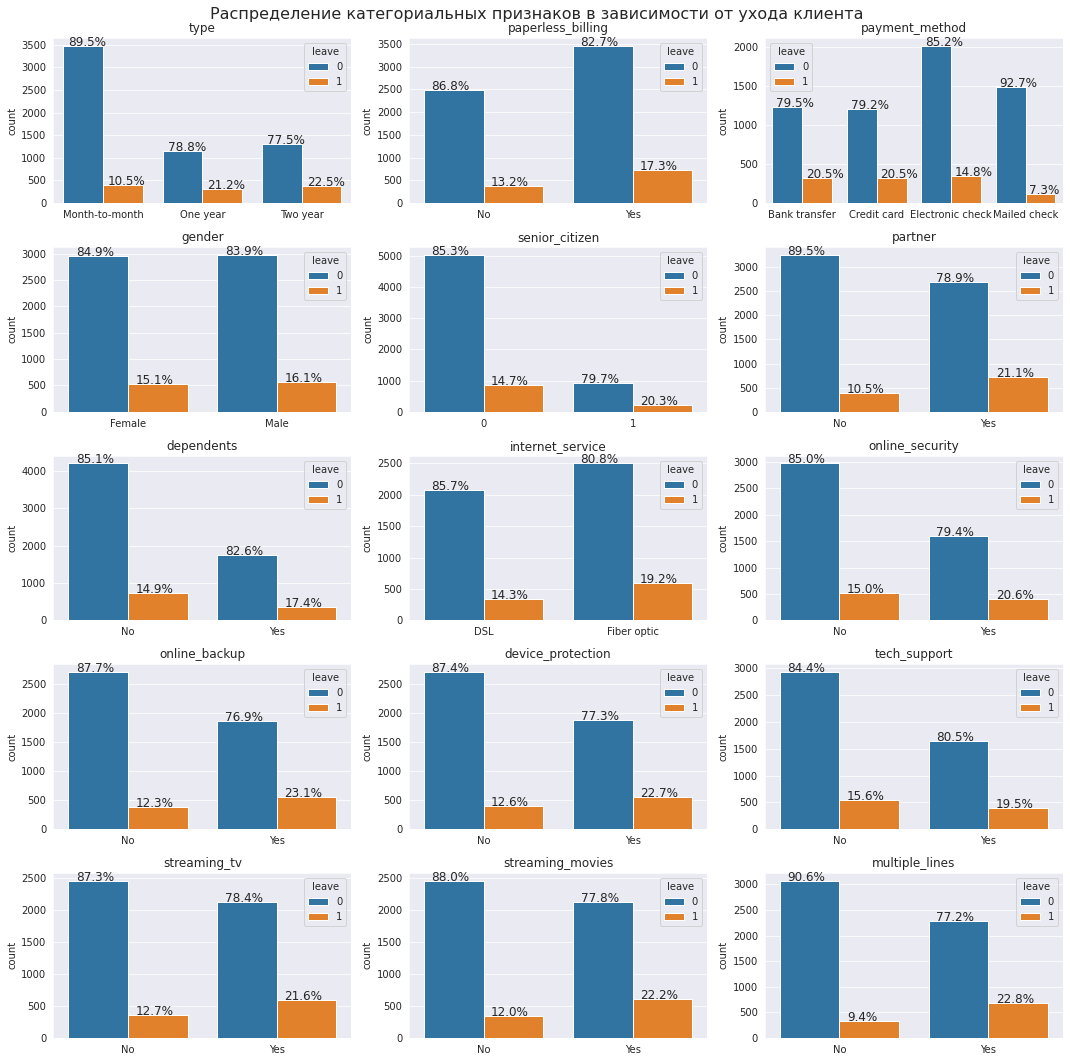

In [53]:
features = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines']

number_row = int(len(features)/3)
fig, ax = plt.subplots(nrows = number_row, ncols=3, figsize=(15, 15))
fig.suptitle('Распределение категориальных признаков в зависимости от ухода клиента', fontsize=16)

# вытягиваем
ax = ax.flatten()

# задаем цикл
for i in range(len(features)):

    name = features[i]
    feature = total_df[name]
    
    t = total_df.groupby(['leave', name])['customer_id'].count().reset_index()
    sns.barplot(data=t, x=name, y='customer_id', hue='leave', ax=ax[i])
    hue_categories = 2

    plot = ax[i]
    plot.set_title(f'{features[i]}')
    plot.set_xlabel('')
    plot.set_ylabel('count')
    
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    categories = total_df[~total_df[name].isna()][name].unique()
    k = 0
    n = len(categories)
    for cat in categories:
        for j in range(hue_categories):
            step = (j*n + k)
            part = a[step]
            cat_value = t[t['customer_id'] == part][name].iloc[0]
            total = t[t[name] == cat_value]['customer_id'].sum()
            
            percentage = '{:.1f}%'.format(100 * part/total)
            x = patch[step].get_x() + patch[step].get_width() / 2 - 0.15
            y = patch[step].get_y() + patch[step].get_height() 
            plot.annotate(percentage, (x, y), size = 12)
        k += 1
             
fig.tight_layout()
fig.show()

**Самый высокий процент клиентов, покидающих компанию, находится среди:**
- Информация по контракту и личная информация:
    - по контракту оплаты за 1-2 года
    - c электронным расчетным листом
    - с типом оплаты переводом банку или кредитной картой
    - пенсионеры
    - находятся в браке
- Интернет услуги:
    - тип подключения fiber optic
    - с подключенными различными услугами
- Телефония:
    - с подключенными услугами нескольких линий
 
**Самый низкий процент клиентов, покидающих компанию, находится среди:**
- с помесячной оплатой
- с типом оплаты с использованием проверки почты
- не находящиеся в браке
- не использующие различные интернет сервисы
- не использующие множественные телефонные линии

**Дополнительные наблюдения:**
- мужчины покидают компанию всего на 1% чаще, чем женщины, поэтому вероятно уход клиента не зависит от пола
- незначительная разница в 2% между уходящими людьми с наличием детей и без

## Количественные признаки

In [54]:
num_columns = ['monthly_charges', 'total_charges', 'contract_duration']

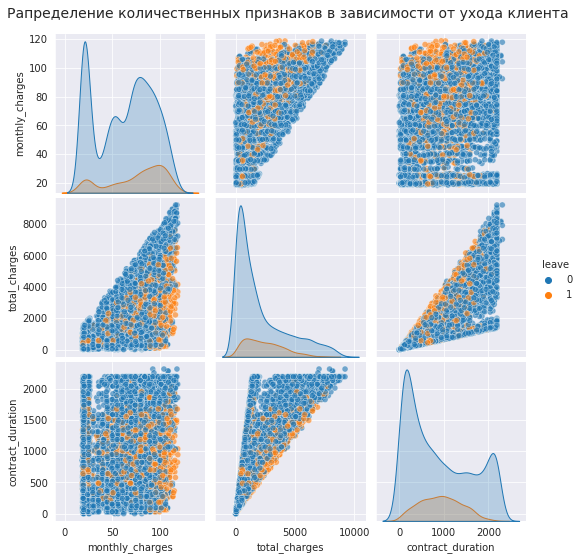

In [55]:
pp = sns.pairplot(
        total_df[num_columns + ['leave']],
        hue='leave',
        plot_kws={'alpha':0.6}
    )
pp.fig.suptitle('Рапределение количественных признаков в зависимости от ухода клиента', y=1.03, fontsize=14)
plt.show();

Большинство уходящих клиентов:
- имеют высокие ежемесячные платежи
- низкие общие траты (что обсулавливается тем, что клиентов с высокими общими тратами в целом мало)
- длительность контракта около 1000 дней, то есть не достигая 3 лет

Дополнительные наблюдения:
- с ростом ежемесячных платежей растет и количество уходящих клиентов
- чем выше ежемесячные платежи, тем выше общие расходы
- длительность контракта не зависит от ежемесячных платежей
- чем дольше длительность контракта, тем выше общие расходы

Посмотрим также на средние показатели.

In [56]:
total_df.groupby('leave')[num_columns].median().T

leave,0,1
monthly_charges,69.2,84.20
total_charges,1192.8,2139.03
contract_duration,702.0,915.00


У уходящих клиентов ежемесячные платежи составляют около 84 руб в среднем, общие расходы около 2.1 тыс. руб в среднем, длительность контракта около 900 дней (2.5 года).

## Корреляционный анализ

Проведем анализ того, с какими признаками целевой признак связан больше всего. Для начала превратим столбец id в индекс таблицы.

In [57]:
total_df = total_df.set_index('customer_id')
total_df.head(3)

,type,paperless_billing,payment_method,monthly_charges,total_charges,leave,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,123


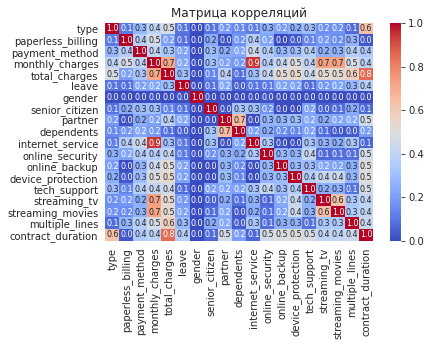

In [58]:
phik_corr = total_df.phik_matrix(interval_cols=num_columns)
sns.heatmap(phik_corr,
            xticklabels=phik_corr.columns.values,
            yticklabels=phik_corr.columns.values,
            cmap='coolwarm',
            annot_kws={"fontsize":8},
            fmt=".1f",
            annot=True)

plt.title('Матрица корреляций')
plt.show();

Наблюдаем наличие мультиколлинеарности между признаками monthly_charges и internet_service. Избавимся от одного из них для устранения мультиколлинеарности. 

Целевой признак leave больше всего зависит от длительности контракта, подключения множественных телефонных линий и общих расходов. Целевой признак практически не зависит от пола клиента и наличия детей, в чём мы также убеждались ранее. Также уберём данные два признака из рассмотрения.

In [59]:
total_df = total_df.drop(columns=['internet_service', 'gender', 'dependents'])

Также отметим наличие достаточной сильной связи ежемесячных платежей от наличия стримингового ТВ и каталога фильмов. Общие расходы сильнее всего зависят от ежемесячных платежей, длительности контракта а также наличия нескольких телефонных линий.

Наблюдается умеренная зависимость между типом оплаты и длительностью контракта, а также между стриминговым ТВ и фильмами. 

## Промежуточные выводы

Выводы:
- создан новый признак - длительность контракта
- целевой признак leave больше всего зависит от длительности контракта, подключения множественных телефонных линий и общих расходов
- чаще всего компанию покидают клиенты:
    - по контракту оплаты за 1-2 года
    - c электронным расчетным листом
    - с типом оплаты переводом банку или кредитной картой
    - пенсионеры
    - находятся в браке
    - тип подключения fiber optic
    - с подключенными различными услугами
    - с подключенными услугами нескольких телефонных линий
    - имеют высокие ежемесячные платежи
    - низкие общие траты (что обсулавливается тем, что клиентов с высокими общими тратами в целом мало)
    - длительность контракта около 1000 дней, то есть не достигая 3 лет
- с ростом ежемесячных платежей растет и количество уходящих клиентов
- у уходящих клиентов ежемесячные платежи составляют около 84 руб в среднем, общие расходы около 2.1 тыс. руб в среднем, длительность контракта около 900 дней (2.5 года)
- признаки тип подключения, пол и наличие детей убраны из рассмотрения
- достаточно сильная связь ежемесячных платежей от наличия стримингового ТВ и каталога фильмов
- общие расходы сильнее всего зависят от ежемесячных платежей, длительности контракта и также наличия нескольких телефонных линий

# Подготовка данных для моделей <a class="anchor" id="step7"></a>

Разделим данные на тренировочную и тестовую выборки.

In [60]:
X = total_df.drop(columns='leave')
y = total_df['leave']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y
)

Обозначим какие признаки требуют кодирования, а какие масштабирования.

In [61]:
# заполним пропуски самыми частыми значениями
ohe_columns = ['type', 'paperless_billing', 'payment_method', 'senior_citizen',
             'partner']

# заполним пропуски значением 'No', поскольку если значение пропущено, 
# то у клиента не подключен данный сервис
ohe_fill_constant = ['online_security', 'online_backup', 'device_protection',
             'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

num_columns = ['monthly_charges', 'total_charges', 'contract_duration']

Подготавливаем пайплайны для обработки данных.

In [62]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ohe_with_const_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ohe_const', ohe_with_const_pipe, ohe_fill_constant),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Обучение моделей <a class="anchor" id="step8"></a>

Для автоматического подбора гиперпараметров будем использовать инструмент RandomizedSearchCV. В словаре укажем, какие варианты масштабирования собираемся перебрать. Их три: варианты с разными методами и один вариант без масштабирования. 

Будем обучать следующие модели: RandomForestClassifier, LGBMClassifier, и LogisticRegression.

В качестве метрики выберем roc_auc, поскольку у нас наблюдается дисбаланс классов.

Создадим функцию, которая будет запускать RandomSearchCV для конкретной модели.

In [63]:
def fit_model(X_train, y_train, model, params):
    '''
        Функция обучает и находит модель с наилучшими переметрами.
    '''
    pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', model(random_state=RANDOM_STATE))
        ]
    )
    
    # задаём случайный поиск
    random_search = RandomizedSearchCV(
        pipe_final, 
        param_distributions=params, 
        scoring='roc_auc',
        random_state=RANDOM_STATE
    )
    
    random_search.fit(X_train, y_train)
    
    print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
    print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)
    
    return random_search.best_estimator_

In [64]:
model1 = fit_model(X_train, y_train, LogisticRegression, [{
                    'models': [LogisticRegression(random_state=RANDOM_STATE)],
                    'models__C': np.arange(0.1, 2, 0.2),
                    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
                }])

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen',
                                                   'partner']),
                                                 ('ohe_const',
                                                  Pipeline(steps=[('simpleImputer_ohe',
    

Логистическая регрессия на данный момент показывает не самые лучшие показатели: 0.76 на тренировочной выборке.

In [65]:
model2 = fit_model(X_train, y_train, RandomForestClassifier, [{
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 40),
        'models__min_samples_split': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }])

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen',
                                                   'partner']),
                                                 ('ohe_const',
                                                  Pipeline(steps=[('simpleImputer_ohe',
    

У случайного леса метрика уже значительно лучше: 0.81 на тренировочной выборке.

In [66]:
model3 = fit_model(X_train, y_train, LGBMClassifier, [{
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 40),
        'models__num_leaves': range(2,40),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }])

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen',
                                                   'partner']),
                                                 ('ohe_const',
                                                  Pipeline(steps=[('simpleImputer_ohe',
    

Безусловно третья LGBM модель самая лучшая с показателем метрики: 0.86 на тренировочной выборке.

In [67]:
best_model = model3

Модель показывает достаточно хорошее качество на тренировочной выборке. Выполним предсказания на тестовой.

In [68]:
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

In [69]:
proba_one = best_model.predict_proba(X_test)[:,1]

acc = roc_auc_score(y_test, proba_one)
print(acc) 

0.9064945552428728


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Получили хорошее качество модели на тестовых данных, чуть выше, чем на тренировочных.

# Анализ важности признаков <a class="anchor" id="step9"></a>

In [70]:
model_preprocessor = best_model.named_steps['preprocessor']
X_test_scalled =  pd.DataFrame(model_preprocessor.transform(X_test), columns = feature_names)

# сформируем таблицу важности признаков
feature_importances = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': best_model.steps[1][1].feature_importances_
    })

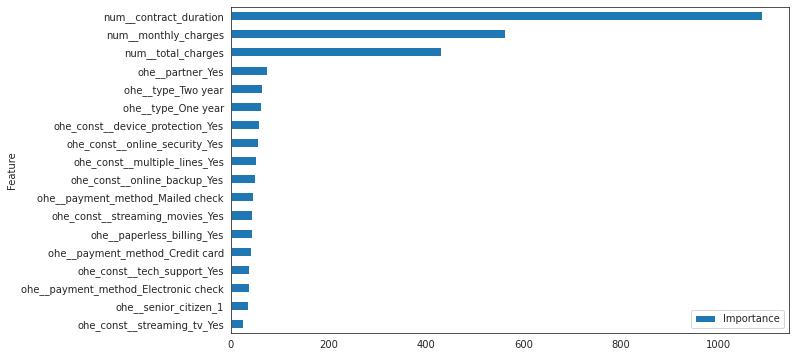

In [71]:
sns.set_style('white')
feature_importances.sort_values('Importance').plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

Отметим, что модель не отдаёт сильное предпочтение исключительно одному признаку, что является хорошим знаком.

Самый важный признак, который выделяет модель это длительность контракта, что логично, самые лояльные клиенты это постоянные клиенты. Второй и третий по важности признаки это ежемесячные траты и общие расходы, мы также наблюдали ранее важность данных признаков в анализе данных.

Самый не важный признак - является ли клиент пенсионером.

# Общий вывод <a class="anchor" id="step9"></a>

**Целью проекта являлось:** разработать модель, которая будет предсказывать, разорвёт ли абонент договор (прогноз оттока клиентов). 

**Лучшая модель:**

1. Лучшая модель: **LGBMClassifier**

2. Параметры: max_depth=14, num_leaves=29

3. Метрика ROC-AUC на тестовой выборке: 0.91

4. Самые важный признаки для модели: длительность контракта, ежемесячные и общие расходы.

5. Самый не важный признак: является ли клиент пенсионером.

**Обработка признаков:**

1. Добавлен новый признак - длительность контракта - рассчитывается от начала до конца контракта, либо до даты скачивания данных по клиентам

2. Признаки тип подключения, пол и наличие детей убраны из рассмотрения (не влияют на результаты). А также признаки начало и конец контракта убраны из рассмотрена, из них сформирован новый признак - длительность контракта.

3. Пропуски по таблицам contract_df и personal_df заполнялись самым часто встречаемым значением, по таблицам internet_df и phone_df значением 'No', поскольку если имеется пропуск, значит клиент не пользуется данными услугами.

**Описание уходящего клиента:** ежемесячные платежи составляют около 84 руб в среднем, общие расходы около 2.1 тыс. руб в среднем, длительность контракта около 900 дней (2.5 года)

<u>Дополнительные наблюдения:</u>
- целевой признак несбалансирован
- аномальных записей в датасете не обнаружено
- последний рост помесячного количества новых клиентов начался с 2019 года
- имеется тенденция к постепенному увеличению количества клиентов покидающих компанию на всём временном промежутке
- с 2015 по 2019 приходило от 50 до 100 клиентов каждый месяц
- расходы клиентов:
    - в среднем клиенты тратят около 70 руб каждый месяц
    - чаще всего клиенты тратят менее 30 руб каждый месяц
    - в среднем клиенты тратят около 1.6 тыс. руб в общем
    - чаще всего общие расходы клиентов не превышают 1 тыс. руб
    - реже всего встречаются общие расходы более 4 тыс. руб
- услуги:
    - около 20% всех клиентов не пользуются интернет услугами, около 10% клиентов не пользуются услугами телефонии
- платежи:
    - с ростом ежемесячных платежей растет и количество уходящих клиентов
    - наблюдается достаточно сильная связь ежемесячных платежей от наличия стримингового ТВ и каталога фильмов
    - общие расходы сильнее всего зависят от ежемесячных платежей, длительности контракта и также наличия нескольких телефонных линий

<u>Чаще всего компанию покидают клиенты:</u>
- по контракту оплаты за 1-2 года
- c электронным расчетным листом
- с типом оплаты переводом банку или кредитной картой
- пенсионеры
- находятся в браке
- тип подключения fiber optic
- с подключенными различными услугами
- с подключенными услугами нескольких телефонных линий
- имеют высокие ежемесячные платежи
- низкие общие траты (что обсулавливается тем, что клиентов с высокими общими тратами в целом мало)
- длительность контракта около 1000 дней, то есть не достигая 3 лет

<u>Рекомендации заказчику:</u> *обратить внимание на следующие моменты*
- начался рост количества новых клиентов с 2019 года
- имеется тенденция к постепенному увеличению количества клиентов покидающих компанию на всём временном промежутке
- с ростом ежемесячных платежей растет и количество уходящих клиентов
- длительность контракта уходящих клиентов не достигает 3 лет